# Caso 2 Intermediário

Para a realização desse caso, será realizado um treinamento utilizando o K-Means no dataset MNIST. O objetivo do modelo é criar cluster para cada imagem de número do MNIST. O modelo do K-Means será utilizado do Sagemaker, realizando o treinamento e a predição do modelo.

Primeiramente, vamos dar um upgrade no sagemaker, garantindo que estaremos utilizando a última versão.

In [2]:
!pip install --upgrade sagemaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.231.0
    Uninstalling sagemaker-2.231.0:
      Successfully uninstalled sagemaker-2.231.0


Vamos incluir as lib do sagemaker para definir o role, sm_session e um bucket default.

In [3]:
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.utils import S3DataConfig

%matplotlib inline

role = get_execution_role()
sm_session = Session()
bucket = sm_session.default_bucket()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/base_serializers.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  import scipy.sparse


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Iremos carregar o dataset no S3.

In [4]:
import pickle, gzip, numpy, boto3, json

# Load the dataset
s3 = boto3.client("s3")
data_bucket = S3DataConfig(
    sm_session, "example-notebooks-data-config", "config/data_config.json"
).get_data_bucket()
print(f"Using data from {data_bucket}")

s3.download_file(data_bucket, "datasets/image/MNIST/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

Using data from sagemaker-sample-files


Plotando uma imagem para observar um exemplo do MNIST.

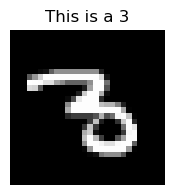

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot is None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], f"This is a {train_set[1][30]}")

Agora, através do Sageaker, vamos carregar o K-Means. Além disso, vamos definir as configurações para rodar o modelo, como o role, número de instâncias, tipo de instância o path dos dados e do output, além de quantos clusters o modelo terá.

In [6]:
from sagemaker import KMeans

data_location = f"s3://{bucket}/kmeans_highlevel_example/data"
output_location = f"s3://{bucket}/kmeans_example/output"

print(f"training data will be uploaded to: {data_location}")
print(f"training artifacts will be uploaded to: {output_location}")

kmeans = KMeans(
    role=role,
    instance_count=2,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    k=10,
    data_location=data_location,
)

training data will be uploaded to: s3://sagemaker-us-east-1-575019173823/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-575019173823/kmeans_example/output


Após definirmos como será o modelo do K-Means, podemos treinar com os dados de treino.

In [7]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-09-21-17-46-10-933


2024-09-21 17:46:12 Starting - Starting the training job...
2024-09-21 17:46:26 Starting - Preparing the instances for training...
2024-09-21 17:46:58 Downloading - Downloading input data...
2024-09-21 17:47:43 Downloading - Downloading the training image.........
2024-09-21 17:49:14 Training - Training image download completed. Training in progress.
2024-09-21 17:49:14 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[09/21/2024 17:49:05 INFO 140087072491328] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_

Para realizar a predição, precisamos primeiramente realizar o deploy, definindo uma única instância do ml.m4.xlarge

In [8]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2024-09-21-17-50-25-963
INFO:sagemaker:Creating endpoint-config with name kmeans-2024-09-21-17-50-25-963
INFO:sagemaker:Creating endpoint with name kmeans-2024-09-21-17-50-25-963


-------!CPU times: user 87.3 ms, sys: 14.3 ms, total: 102 ms
Wall time: 4min 2s


In [10]:
%%time

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

CPU times: user 30.8 ms, sys: 176 μs, total: 31 ms
Wall time: 65.5 ms


Após a realização da predição com os dados de validação, vamos plotar as imagens que foram colocadas em cada cluster.




Cluster 0:


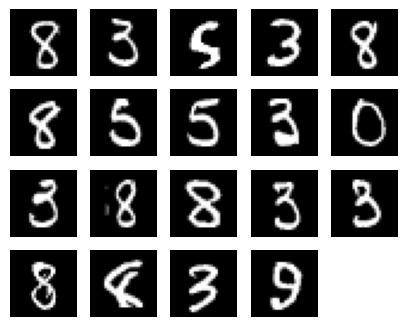




Cluster 1:


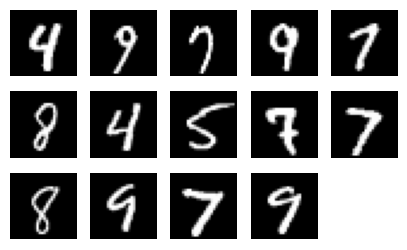




Cluster 2:


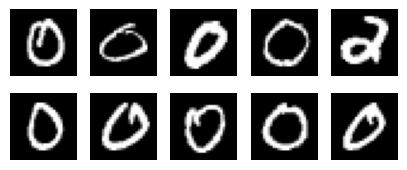




Cluster 3:


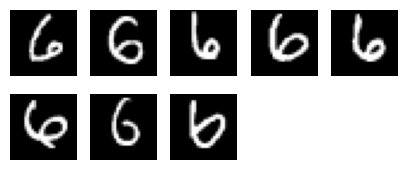




Cluster 4:


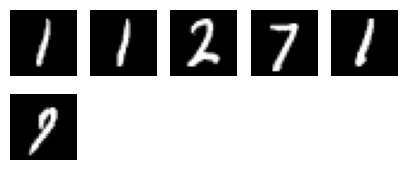




Cluster 5:


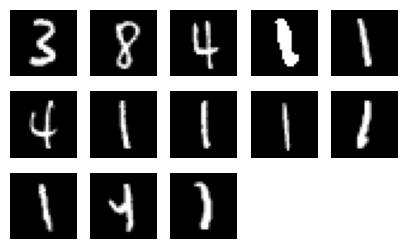




Cluster 6:


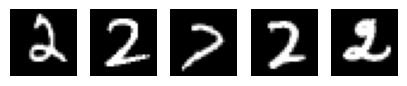




Cluster 7:


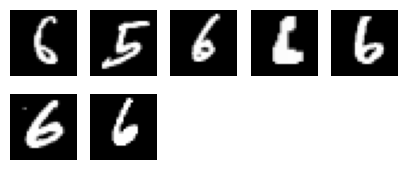




Cluster 8:


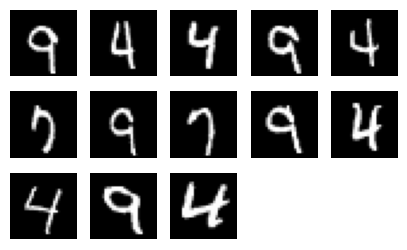




Cluster 9:


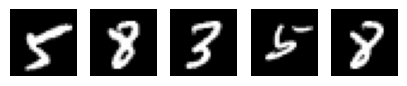

In [11]:
for cluster in range(10):
    print(f"\n\n\nCluster {int(cluster)}:")
    digits = [img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster]
    """
        The KMeans algorithm as an optimization problem is an NP Complete problem, and internal implementations
        can produce different results for each run, depending upon the locations of the initial cluster centroid.
        In some cases, there might be no data points in a cluster. We plot below the data points for clusters which
        have datapoints.
    """
    if digits:
        height = ((len(digits) - 1) // 5) + 1
        width = 5
        plt.rcParams["figure.figsize"] = (width, height)
        _, subplots = plt.subplots(height, width)
        subplots = numpy.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            show_digit(image, subplot=subplot)
        for subplot in subplots[len(digits) :]:
            subplot.axis("off")
        plt.show()

Portanto, podemos observar que o modleo errou muito, fazendo com que o K-Means não seja a melhor escolha para a resolução desse problema. Contudo, podemos observar a praticidade de utilizar o Sagemaker para a realização de treinamento de modelos, após o treinamento do node, realizar a predição se torna uma tarefa simples.

Por fim, vamos deletar o endpoint criado para realizar a predição.

In [12]:
kmeans_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: kmeans-2024-09-21-17-50-25-963
INFO:sagemaker:Deleting endpoint with name: kmeans-2024-09-21-17-50-25-963
